# Introduction

Let's learn how to ingest a PDF file into Weaviate using Unstructured!

# Data

Here's a screenshot of the sample data:

![image.png](./pdf01_snippet.png)

# The Basics

You can convert a PDF to text in just one function call:

In [1]:
from unstructured.partition.pdf import partition_pdf

In [2]:
elements = partition_pdf(filename="../data/paper01.pdf")

In [3]:
for elem in elements[:10]:
    print(elem)

A survey on Image Data Augmentation for Deep Learning
Connor Shorten* and Taghi M. Khoshgoftaar
*Correspondence: cshorten2015@fau.edu Department of Computer and Electrical Engineering and Computer Science, Florida Atlantic University, Boca Raton, USA
Abstract
Deep convolutional neural networks have performed remarkably well on many Computer Vision tasks. However, these networks are heavily reliant on big data to avoid overfitting. Overfitting refers to the phenomenon when a network learns a function with very high variance such as to perfectly model the training data. Unfor
tunately, many application domains do not have access to big data, such as medical image analysis. This survey focuses on Data Augmentation, a data
space solution to the problem of limited data. Data Augmentation encompasses a suite of techniques that enhance the size and quality of training datasets such that better Deep Learning models can be built using them. The image augmentation algorithms discussed in this su

Titles have their own category.

Here are all the titles that Unstructured was able to find:

In [4]:
titles = [elem for elem in elements if elem.category == "Title"]

for title in titles:
    print(title.text)

A survey on Image Data Augmentation for Deep Learning
Abstract
Introduction
Background
Image Data Augmentation techniques
Data Augmentations based on basic image manipulations
Flipping
Color space
Cropping
Rotation
Translation
Noise injection
Color space transformations
Geometric versus photometric transformations
Kernel filters
Mixing images
Random erasing
A note on combining augmentations
Data Augmentations based on Deep Feature space augmentation
Data Augmentations based on Deep Learning
Feature space augmentation
Adversarial training
GAN‑based Data Augmentation
Generated images
Neural Style Transfer
Meta learning Data Augmentations
Comparing Augmentations
Design considerations for image Data Augmentation
Test-time augmentation
Curriculum learning
Resolution impact
Final dataset size
Alleviating class imbalance with Data Augmentation
Discussion
Future work
Conclusion
Abbreviations
Acknowledgements
Authors’ contributions
Funding
References
Publisher’s Note


It was able to recognize most of the titles, but not all of them. 

Example of missing titles:

* Availability of data and materials
* Competing interests
* Consent for publication

The content of a title is a NarrativeText object:

In [5]:
import textwrap

narrative_texts = [elem for elem in elements if elem.category == "NarrativeText"]

for index, elem in enumerate(narrative_texts[:5]):
    print(f"Narrative text {index + 1}:")
    print("\n".join(textwrap.wrap(elem.text, width=70)))
    print("\n" + "-" * 70 + "\n")

Narrative text 1:
Connor Shorten* and Taghi M. Khoshgoftaar

----------------------------------------------------------------------

Narrative text 2:
*Correspondence: cshorten2015@fau.edu Department of Computer and
Electrical Engineering and Computer Science, Florida Atlantic
University, Boca Raton, USA

----------------------------------------------------------------------

Narrative text 3:
Deep convolutional neural networks have performed remarkably well on
many Computer Vision tasks. However, these networks are heavily
reliant on big data to avoid overfitting. Overfitting refers to the
phenomenon when a network learns a function with very high variance
such as to perfectly model the training data. Unfor- tunately, many
application domains do not have access to big data, such as medical
image analysis. This survey focuses on Data Augmentation, a data-space
solution to the problem of limited data. Data Augmentation encompasses
a suite of techniques that enhance the size and quality 

One option is to vectorize all the narrative texts and store it in Weaviate!

# Advanced Stuff

What if we are only interested in extracting the abstract?

We build a state machine that can extract the narrative texts under the abstract section given a list of elements:

In [6]:
import logging

logging.basicConfig(level=logging.INFO)


class AbstractExtractor:
    def __init__(self):
        self.current_section = None  # Keep track of the current section being processed
        self.have_extracted_abstract = (
            False  # Keep track of whether the abstract has been extracted
        )
        self.in_abstract_section = (
            False  # Keep track of whether we're inside the Abstract section
        )
        self.texts = []  # Keep track of the extracted abstract text

    def process(self, element):
        if element.category == "Title":
            self.set_section(element.text)

            if self.current_section == "Abstract":
                self.in_abstract_section = True
                return True

            if self.in_abstract_section:
                return False

        if self.in_abstract_section and element.category == "NarrativeText":
            self.consume_abstract_text(element.text)
            return True

        return True

    def set_section(self, text):
        self.current_section = text
        logging.info(f"Current section: {self.current_section}")

    def consume_abstract_text(self, text):
        logging.info(f"Abstract part extracted: {text}")
        self.texts.append(text)

    def consume_elements(self, elements):
        for element in elements:
            should_continue = self.process(element)

            if not should_continue:
                self.have_extracted_abstract = True
                break

        if not self.have_extracted_abstract:
            logging.warning("No abstract found in the given list of objects.")

    def abstract(self):
        return "\n".join(self.texts)

Using the class:

In [7]:
abstract_extractor = AbstractExtractor()
abstract_extractor.consume_elements(elements)

INFO:root:Current section: A survey on Image Data Augmentation for Deep Learning
INFO:root:Current section: Abstract
INFO:root:Abstract part extracted: Deep convolutional neural networks have performed remarkably well on many Computer Vision tasks. However, these networks are heavily reliant on big data to avoid overfitting. Overfitting refers to the phenomenon when a network learns a function with very high variance such as to perfectly model the training data. Unfor- tunately, many application domains do not have access to big data, such as medical image analysis. This survey focuses on Data Augmentation, a data-space solution to the problem of limited data. Data Augmentation encompasses a suite of techniques that enhance the size and quality of training datasets such that better Deep Learning models can be built using them. The image augmentation algorithms discussed in survey include geometric transformations, color space augmentations, kernel filters, mixing images, random erasing

The extracted abstract is:

In [8]:
print("\n".join(textwrap.wrap(abstract_extractor.abstract(), width=70)))

Deep convolutional neural networks have performed remarkably well on
many Computer Vision tasks. However, these networks are heavily
reliant on big data to avoid overfitting. Overfitting refers to the
phenomenon when a network learns a function with very high variance
such as to perfectly model the training data. Unfor- tunately, many
application domains do not have access to big data, such as medical
image analysis. This survey focuses on Data Augmentation, a data-space
solution to the problem of limited data. Data Augmentation encompasses
a suite of techniques that enhance the size and quality of training
datasets such that better Deep Learning models can be built using
them. The image augmentation algorithms discussed in survey include
geometric transformations, color space augmentations, kernel filters,
mixing images, random erasing, feature space augmentation, adversarial
training, generative adversarial networks, neural style transfer, and
meta-learning. The applica- tion of augm

# End-to-End Example

Let's read a folder containing research papers stored as PDFs, extract their abstracts and store them in Weaviate.

In [9]:
from pathlib import Path
import weaviate
from weaviate.embedded import EmbeddedOptions
import os

First, we initialize Weaviate:

In [10]:
client = weaviate.Client(
    embedded_options=EmbeddedOptions(
        additional_env_vars={"OPENAI_APIKEY": os.environ["OPENAI_APIKEY"]}
    )
)

Binary /home/.cache/weaviate-embedded did not exist. Downloading binary from https://github.com/weaviate/weaviate/releases/download/v1.18.3/weaviate-v1.18.3-linux-amd64.tar.gz
Started /home/.cache/weaviate-embedded: process ID 1819


{"action":"startup","default_vectorizer_module":"none","level":"info","msg":"the default vectorizer modules is set to \"none\", as a result all new schema classes without an explicit vectorizer setting, will use this vectorizer","time":"2023-05-12T17:53:17Z"}
{"action":"startup","auto_schema_enabled":true,"level":"info","msg":"auto schema enabled setting is set to \"true\"","time":"2023-05-12T17:53:17Z"}
{"level":"warning","msg":"Multiple vector spaces are present, GraphQL Explore and REST API list objects endpoint module include params has been disabled as a result.","time":"2023-05-12T17:53:17Z"}
{"action":"restapi_management","level":"info","msg":"Serving weaviate at http://127.0.0.1:6666","time":"2023-05-12T17:53:17Z"}
/usr/local/lib/python3.8/subprocess.py:946: ResourceWarning: subprocess 1819 is still running
  _warn("subprocess %s is still running" % self.pid,


In [11]:
client.schema.delete_all()

schema = {
    "class": "Document",
    "vectorizer": "text2vec-openai",
    "properties": [
        {
            "name": "source",
            "dataType": ["text"],
        },
        {
            "name": "abstract",
            "dataType": ["text"],
            "moduleConfig": {
                "text2vec-openai": {"skip": False, "vectorizePropertyName": False}
            },
        },
    ],
    "moduleConfig": {
        "generative-openai": {},
        "text2vec-openai": {"model": "ada", "modelVersion": "002", "type": "text"},
    },
}

client.schema.create_class(schema)

{"action":"hnsw_vector_cache_prefill","count":25000,"index_id":"document_EcjeDk9PwLnM","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2023-05-12T17:53:17Z","took":1226228}


Next, we build the objects that we want to store in Weaviate:

In [12]:
data_folder = "../data"

data_objects = []

for path in Path(data_folder).iterdir():
    if path.suffix != ".pdf":
        continue

    print(f"Processing {path.name}...")

    elements = partition_pdf(filename=path)

    abstract_extractor = AbstractExtractor()
    abstract_extractor.consume_elements(elements)

    data_object = {"source": path.name, "abstract": abstract_extractor.abstract()}

    data_objects.append(data_object)

INFO:unstructured_inference:Loading the Detectron2 layout model ...


Processing paper01.pdf...


INFO:detectron2.checkpoint.detection_checkpoint:[DetectionCheckpointer] Loading from /home/.cache/huggingface/hub/models--layoutparser--detectron2/snapshots/bdedfd979ad33a5713af334da14ec09688e7e9de/PubLayNet/faster_rcnn_R_50_FPN_3x/model_final.pth ...
INFO:fvcore.common.checkpoint:[Checkpointer] Loading from /home/.cache/huggingface/hub/models--layoutparser--detectron2/snapshots/bdedfd979ad33a5713af334da14ec09688e7e9de/PubLayNet/faster_rcnn_R_50_FPN_3x/model_final.pth ...
INFO:unstructured_inference:Reading PDF for file: ../data/paper01.pdf ...
INFO:unstructured_inference:Detecting page elements ...
INFO:unstructured_inference:Detecting page elements ...
INFO:unstructured_inference:Detecting page elements ...
INFO:unstructured_inference:Detecting page elements ...
INFO:unstructured_inference:Detecting page elements ...
INFO:unstructured_inference:Detecting page elements ...
INFO:unstructured_inference:Detecting page elements ...
INFO:unstructured_inference:Detecting page elements ...
I

Processing paper02.pdf...


INFO:detectron2.checkpoint.detection_checkpoint:[DetectionCheckpointer] Loading from /home/.cache/huggingface/hub/models--layoutparser--detectron2/snapshots/bdedfd979ad33a5713af334da14ec09688e7e9de/PubLayNet/faster_rcnn_R_50_FPN_3x/model_final.pth ...
INFO:fvcore.common.checkpoint:[Checkpointer] Loading from /home/.cache/huggingface/hub/models--layoutparser--detectron2/snapshots/bdedfd979ad33a5713af334da14ec09688e7e9de/PubLayNet/faster_rcnn_R_50_FPN_3x/model_final.pth ...
INFO:unstructured_inference:Reading PDF for file: ../data/paper02.pdf ...
INFO:unstructured_inference:Detecting page elements ...
INFO:unstructured_inference:Detecting page elements ...
INFO:unstructured_inference:Detecting page elements ...
INFO:unstructured_inference:Detecting page elements ...
INFO:root:Current section: A Comparison of House Price Classification with Structured and Unstructured
INFO:root:Current section: Connor Shorten
INFO:root:Current section: Abstract
INFO:root:Abstract part extracted: fident an

Finally, we upload the data objects to Weaviate:

In [13]:
with client.batch as batch:
    for data_object in data_objects:
        batch.add_data_object(data_object, "Document")

Check how many objects we have:

In [14]:
client.data_object.get(class_name="Document")['totalResults']

2

And now we can do some queries:

In [15]:
client.query.get("Document", "source").with_bm25(
    query="some paper about housing prices"
).with_additional("score").do()

{'data': {'Get': {'Document': [{'_additional': {'score': '0.8450042'},
     'source': 'paper02.pdf'},
    {'_additional': {'score': '0.26854637'}, 'source': 'paper01.pdf'}]}}}

In [16]:
prompt = """
Please summarize the following academic abstract in a one-liner for a layperson:

{abstract}
"""

results = (
    client.query.get("Document", "source").with_generate(single_prompt=prompt).do()
)

docs = results["data"]["Get"]["Document"]

for doc in docs:
    source = doc["source"]
    abstract = doc["_additional"]["generate"]["singleResult"]
    wrapped_abstract = textwrap.fill(abstract, width=80)
    print(f"Source: {source}\nSummary:\n{wrapped_abstract}\n")

Source: paper01.pdf
Summary:
Data Augmentation is a technique that enhances the size and quality of training
datasets for Deep Learning models, particularly useful in domains with limited
data such as medical image analysis.

Source: paper02.pdf
Summary:
Using machine learning techniques, researchers explore predicting house prices
with structured and unstructured data, finding that the best predictive
performance is achieved with term frequency-inverse document frequency (TF-IDF)
representations of house descriptions.



# Limitations

The abstract for `paper02.pdf` was not extracted correctly:

In [17]:
results = client.query.get("Document", "abstract").with_where({
    "path": "source",
    "operator": "Equal",
    "valueText": "paper02.pdf"
}).do()

print(results["data"]["Get"]["Document"][0]["abstract"])

fident and make decisions quicker, leading to a more effi- cient market. Forecasting house prices is a tool for trans- parent pricing that we explore with machine learning tech- niques.
Purchasing a home is one of the largest investments most people make. House price prediction allows indi- viduals to be informed about their asset wealth. Trans- parent pricing on homes allows for a more efficient mar- ket and economy. We report the performance of ma- chine learning models trained with structured tabular representations and unstructured text descriptions. We collected a dataset of 200 descriptions of houses which include meta-information, as well as text descriptions. We test logistic regression and multi-layer perceptron (MLP) classifiers on dividing these houses into binary buckets based on fixed price thresholds. We present an exploration into strategies to represent unstructured text descriptions of houses as inputs for machine learning models. This includes a comparison of term fre

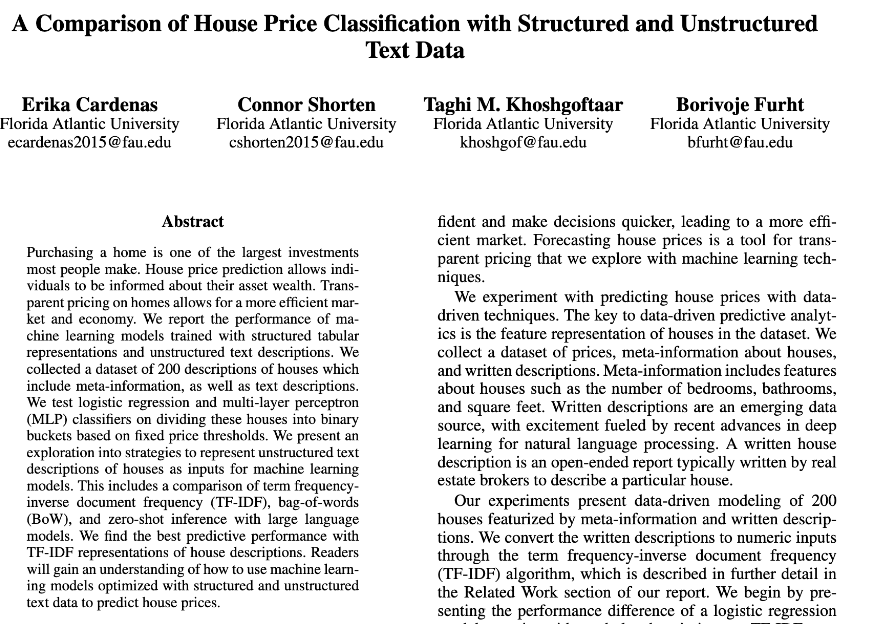

Explanation:

`paper02.pdf` is a two-column document. The abstract is in the left column only but some of the text in the right column was also extracted and included in the abstract.

Workaround:

We can try a different strategy when parsing the document:

In [18]:
elements = partition_pdf(filename="../data/paper02.pdf", strategy="ocr_only")
abstract_extractor = AbstractExtractor()
abstract_extractor.consume_elements(elements)
print(abstract_extractor.abstract())

/usr/local/lib/python3.8/ast.py:47: ResourceWarning: unclosed file <_io.BufferedReader name='../data/paper01.pdf'>
  return compile(source, filename, mode, flags,
/usr/local/lib/python3.8/ast.py:47: ResourceWarning: unclosed file <_io.BufferedReader name='../data/paper02.pdf'>
  return compile(source, filename, mode, flags,


ValueError: ocr_only is an invalid parsing strategy for PDFs

another strategy:

In [19]:
elements = partition_pdf(filename="../data/paper02.pdf", strategy="fast")
abstract_extractor = AbstractExtractor()
abstract_extractor.consume_elements(elements)

INFO:root:Current section: A Comparison of House Price Classification with Structured and Unstructured Text Data
INFO:root:Current section: Erika Cardenas Florida Atlantic University ecardenas2015@fau.edu
INFO:root:Current section: Connor Shorten Florida Atlantic University cshorten2015@fau.edu
INFO:root:Current section: Taghi M. Khoshgoftaar Florida Atlantic University khoshgof@fau.edu
INFO:root:Current section: Borivoje Furht Florida Atlantic University bfurht@fau.edu
INFO:root:Current section: Abstract
INFO:root:Abstract part extracted: Purchasing a home is one of the largest investments most people make. House price prediction allows indi- viduals to be informed about their asset wealth. Trans- parent pricing on homes allows for a more efficient mar- ket and economy. We report the performance of ma- chine learning models trained with structured tabular representations and unstructured text descriptions. We collected a dataset of 200 descriptions of houses which include meta-informa

In [20]:
import textwrap

abstract = abstract_extractor.abstract()
wrapped_abstract = textwrap.fill(abstract, width=80)
print(wrapped_abstract)

Purchasing a home is one of the largest investments most people make. House
price prediction allows indi- viduals to be informed about their asset wealth.
Trans- parent pricing on homes allows for a more efficient mar- ket and economy.
We report the performance of ma- chine learning models trained with structured
tabular representations and unstructured text descriptions. We collected a
dataset of 200 descriptions of houses which include meta-information, as well as
text descriptions. We test logistic regression and multi-layer perceptron (MLP)
classifiers on dividing these houses into binary buckets based on fixed price
thresholds. We present an exploration into strategies to represent unstructured
text descriptions of houses as inputs for machine learning models. This includes
a comparison of term frequency- inverse document frequency (TF-IDF), bag-of-
words (BoW), and zero-shot inference with large language models. We find the
best predictive performance with TF-IDF representations 

This one includes the abstract but also includes the entire introduction section on the first page 🥲

Upvote [issue #356](https://github.com/Unstructured-IO/unstructured/issues/356) if you want better support for two-column documents!

# Conclusion

Thanks for following along this demo! If you'd like to see a staging brick for Weaviate in Unstructured, then give [issue #566](https://github.com/Unstructured-IO/unstructured/issues/566) an upvote! 